In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
# hyperparameters
input_size = 784
hidden_size_1 = 150
hidden_size_2 = 100
num_classes = 10

epochs = 15

learning_rate = 0.001

**Loading data**

In [ ]:
mnist_train = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [ ]:
mnist_test= dsets.MNIST(root='./data', train=False, download= False, transform=transforms.ToTensor())

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset= mnist_train, batch_size = 100, shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset= mnist_test, batch_size = 500, shuffle= False)

**Train and test size and type**

In [ ]:
for (X_train,y_train) in train_loader:
  print("X_train:", X_train.size(), "type", X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break
for (X_test,y_test) in test_loader:
  print("X_test:", X_test.size(), "type", X_test.type())
  print('y_test:', y_test.size(), 'type:', y_test.type())
  break

X_train: torch.Size([100, 1, 28, 28]) type torch.FloatTensor
y_train: torch.Size([100]) type: torch.LongTensor
X_test: torch.Size([500, 1, 28, 28]) type torch.FloatTensor
y_test: torch.Size([500]) type: torch.LongTensor


**Data visualization**

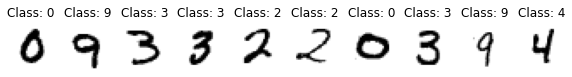

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

**Modelling**

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
    super().__init__()

    self.l1 = nn.Linear(input_size,hidden_size_1)
    self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.l3 = nn.Linear(hidden_size_2, output_size)

  def forward(self,X):
    X = torch.sigmoid(self.l1(X))
    X = torch.sigmoid(self.l2(X))
    X = self.l3(X)
    return X
  

In [ ]:
model = Model(input_size, hidden_size_1, hidden_size_2, num_classes)

In [ ]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

print(model)

Model(
  (l1): Linear(in_features=784, out_features=150, bias=True)
  (l2): Linear(in_features=150, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# training
train_losses = []
test_losses = []
train_correct = []
test_correct= []


for i in range(epochs):
  train_corr = 0
  test_corr = 0
  total_loss= 0

  for step,(X_train, y_train) in enumerate(train_loader):
    step += 1

    # Apply the model 

    y_pred = model(X_train.view(100,-1))
    loss = criterion(y_pred, y_train)
    total_loss += loss

    # Calculate the number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted==y_train).sum()
    train_corr += batch_corr

    # Update parameters
    optimizer.zero_grad() # reset the gradients after each training step
    loss.backward() # to trigger backprop
    optimizer.step() # perform parameter update

    # Print interim results

    if step%600 == 0:
      print(f"epoch: {i+1} Train loss: {total_loss.item()/600} Train accuracy: {train_corr.item()/60000}")
    
    
  # Update train loss & accuracy for the epoch
  train_losses.append(total_loss/600)
  train_correct.append(train_corr) 

  # Run the testing batches
  total_loss= 0
  predictions= []
  true_labels= []
  with torch.no_grad(): # don't calculate gradients during testing
    for step, (X_test, y_test) in enumerate(test_loader):
      step += 1

      # Apply the model
      y_val = model(X_test.view(500,-1))

      predicted = torch.max(y_val.data,1)[1]
      test_corr += (predicted == y_test).sum()

      predictions.append(predicted)
      true_labels.append(y_test)

      # Update test loss & accuracy for the epoch 
      loss = criterion(y_val, y_test)
      total_loss += loss

      if step%20 == 0:
        print(f"epoch: {i+1} Test loss: {total_loss.item()/20} Test accuracy: {test_corr.item()/10000}")

    test_losses.append(total_loss/20)
    test_correct.append(test_corr)



epoch: 1 Train loss: 0.747686767578125 Train accuracy: 0.8034166666666667
epoch: 1 Test loss: 0.2864219665527344 Test accuracy: 0.9188
epoch: 2 Train loss: 0.23862101236979166 Train accuracy: 0.9314833333333333
epoch: 2 Test loss: 0.19835517406463624 Test accuracy: 0.9406
epoch: 3 Train loss: 0.17173399607340495 Train accuracy: 0.95035
epoch: 3 Test loss: 0.1555253267288208 Test accuracy: 0.9526
epoch: 4 Train loss: 0.13330000559488933 Train accuracy: 0.9611166666666666
epoch: 4 Test loss: 0.12862595319747924 Test accuracy: 0.9614
epoch: 5 Train loss: 0.1073471196492513 Train accuracy: 0.9694
epoch: 5 Test loss: 0.11211254596710205 Test accuracy: 0.965
epoch: 6 Train loss: 0.08768373489379883 Train accuracy: 0.9747833333333333
epoch: 6 Test loss: 0.10685462951660156 Test accuracy: 0.9678
epoch: 7 Train loss: 0.07358594258626303 Train accuracy: 0.9788
epoch: 7 Test loss: 0.09382563829421997 Test accuracy: 0.9705
epoch: 8 Train loss: 0.06109528223673503 Train accuracy: 0.9821666666666666

In [ ]:
# Test accuracy
print(f"Test accuracy: {test_correct[-1].item()*100/10000}%")

Test accuracy: 97.69%


**Loss graphs**

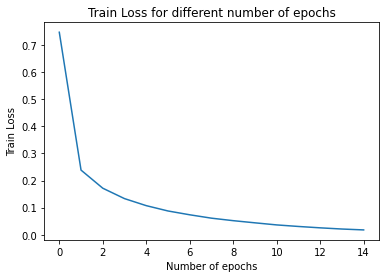

In [ ]:
with torch.no_grad():
  plt.plot(train_losses)
  plt.title("Train Loss for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Train Loss")


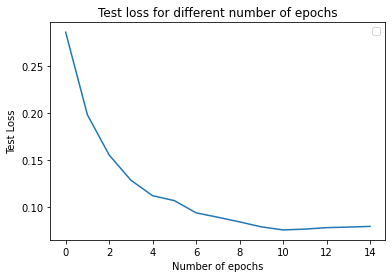

In [ ]:
with torch.no_grad():
  plt.plot(test_losses)
  plt.title("Test loss for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Test Loss")
  plt.legend()

**Performance graphs**

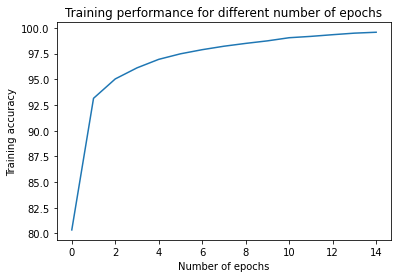

In [ ]:
with torch.no_grad():
  plt.plot([t/600 for t in train_correct])
  plt.title("Training performance for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Training accuracy")

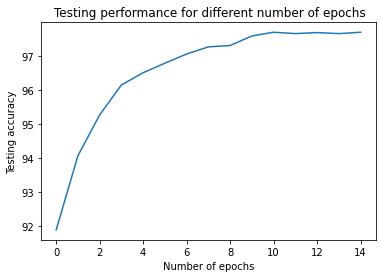

In [ ]:
with torch.no_grad():
  plt.plot([t/100 for t in test_correct])
  plt.title(" Testing performance for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Testing accuracy")

In order to get confusion matrix, precision score, recall score and f1 score, predictions and true labels are needed

In [ ]:
len(predictions)  # predictions list has 20 batch, every batch has 500 sample

20

In [ ]:
prediction_list= []
for i in predictions:
  for j in i:
    prediction_list.append(j.item())

In [ ]:
label_list= []
for i in true_labels:
  for j in i:
    label_list.append(j.item())

**Scores**

In [ ]:
print(confusion_matrix(label_list, prediction_list))
print("Precision score:", precision_score(label_list, prediction_list,  average="micro"))
print("Recall score:", recall_score(label_list, prediction_list, average="micro"))
print("F1_score:", f1_score(label_list, prediction_list,average="micro"))

[[ 970    0    2    1    0    3    1    1    1    1]
 [   0 1123    2    2    0    1    2    2    3    0]
 [   3    2 1006    7    1    1    1    6    5    0]
 [   0    0    0 1003    0    1    0    3    3    0]
 [   1    0    1    1  950    0    7    5    1   16]
 [   2    0    0   18    2  854    4    2    8    2]
 [   6    4    1    1    1    2  935    1    7    0]
 [   0    3    7    4    1    1    0 1003    3    6]
 [   2    0    2    8    2    3    3    2  951    1]
 [   1    2    0   10    3    3    2    9    5  974]]
Precision score: 0.9769
Recall score: 0.9769
F1_score: 0.9769
